# Prezentacja danych datasetu MSL

### Wczytanie danych

In [2]:
import os
import numpy as np
import pandas as pd

train_data_dir = os.path.join("data/train")
test_data_dir = os.path.join("data/test")

metadata = pd.read_csv("labeled_anomalies.csv")
msl_channels = metadata[metadata['spacecraft'] == 'MSL']['chan_id'].tolist()

# Wczytanie danych treningowych
train_data = {}
for channel in msl_channels:
    npy_path = os.path.join(train_data_dir, f"{channel}.npy")
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        train_data[channel] = arr[:, 0] 
    else:
        print(f"Brak pliku: {npy_path}")

# Wczytanie danych testowych
test_data = {}
for channel in msl_channels:
    npy_path = os.path.join(test_data_dir, f"{channel}.npy")
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        test_data[channel] = arr[:, 0] 
    else:
        print(f"Brak pliku: {npy_path}")

del arr, channel, npy_path, train_data_dir, test_data_dir


In [ ]:
# Etykietowanie danych testowych na podstawie metadanych
test_data_labeled = {}
for channel in msl_channels:
    values = test_data[channel]
    
    labels = np.array(['Normal'] * len(values), dtype=object)
    
    # Przedziały anomalii dla danego kanału
    channel_meta = metadata[metadata['chan_id'] == channel]
    if not channel_meta.empty:
        seq_str = channel_meta.iloc[0]['anomaly_sequences']
        if pd.notnull(seq_str) and seq_str != '[]':
            anomaly_intervals = eval(seq_str)
            for start, end in anomaly_intervals:
                start_idx = max(0, start)
                end_idx = min(len(values)-1, end)
                labels[start_idx:end_idx+1] = 'Anomaly'
    
    df = pd.DataFrame({'value': values, 'Normal/Anomaly': labels})
    test_data_labeled[channel] = df

del channel, values, labels, start, end, start_idx, end_idx, seq_str, channel_meta, anomaly_intervals, df

### Dane na wykresach

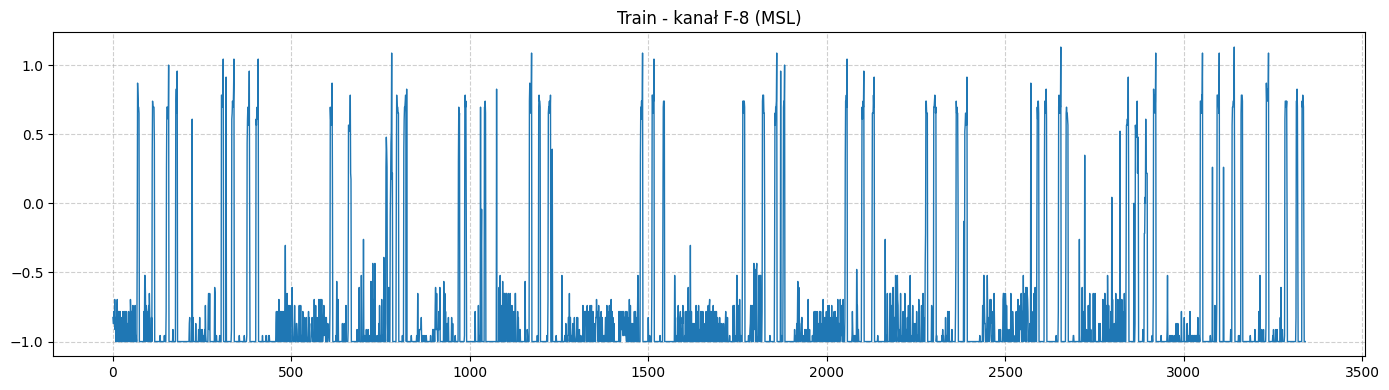

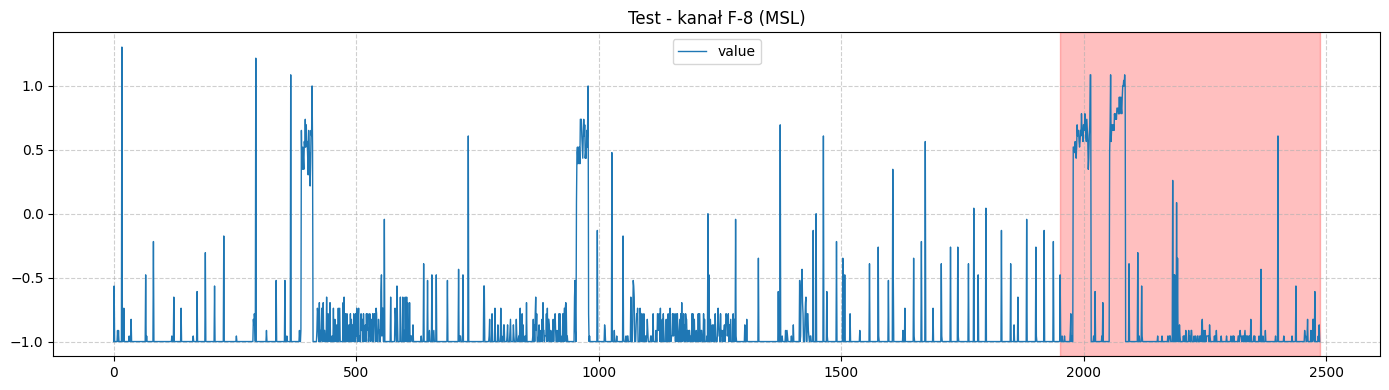

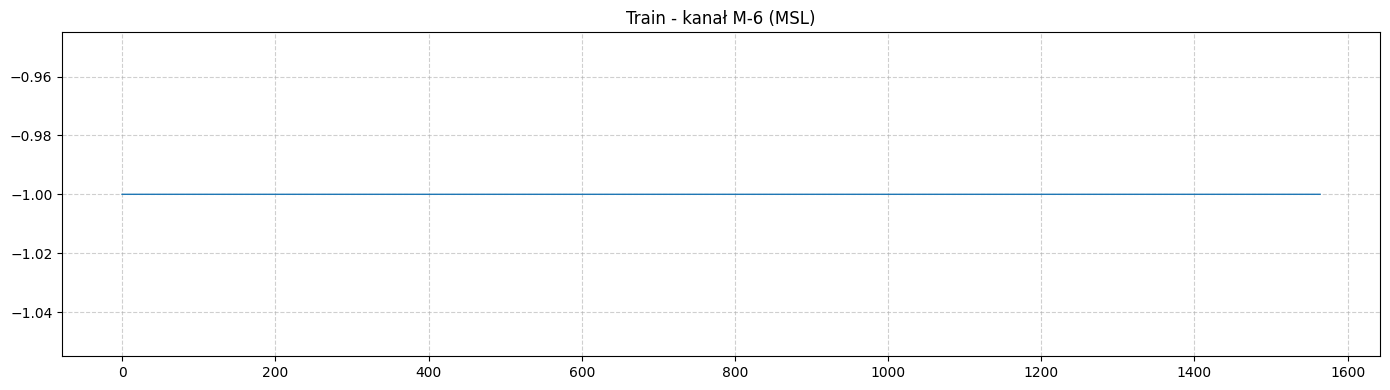

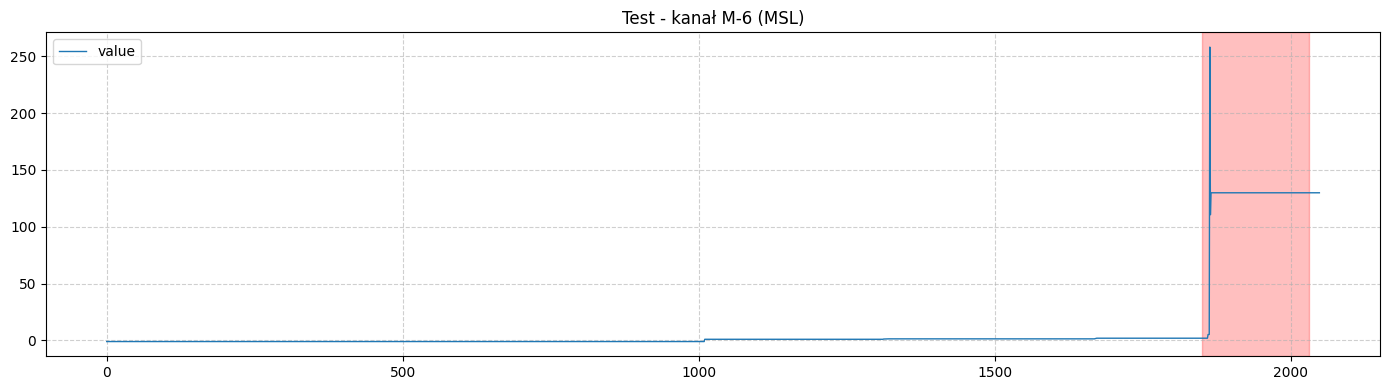

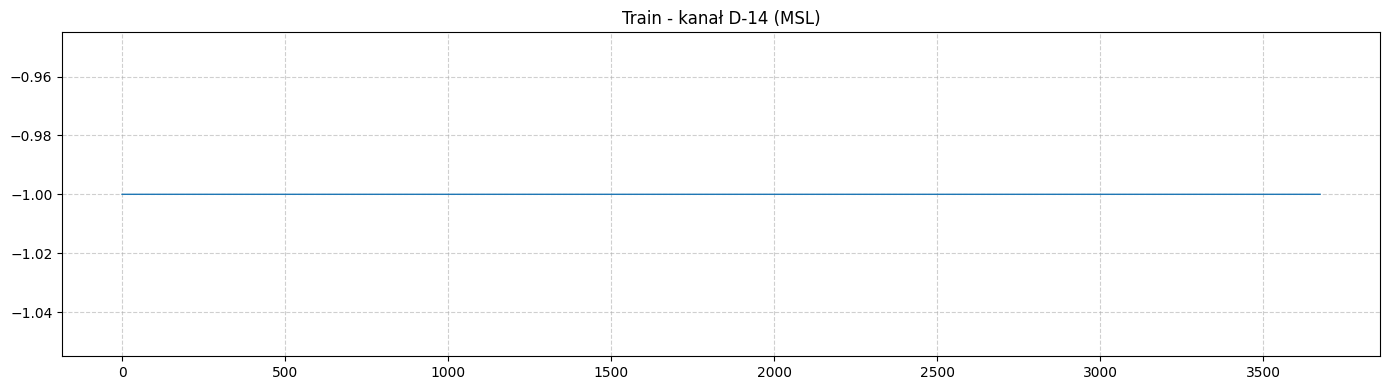

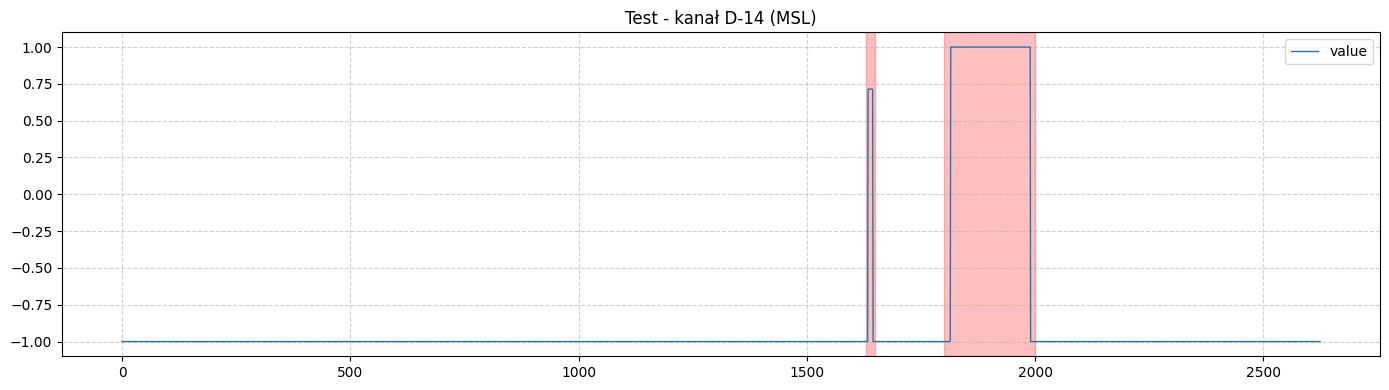

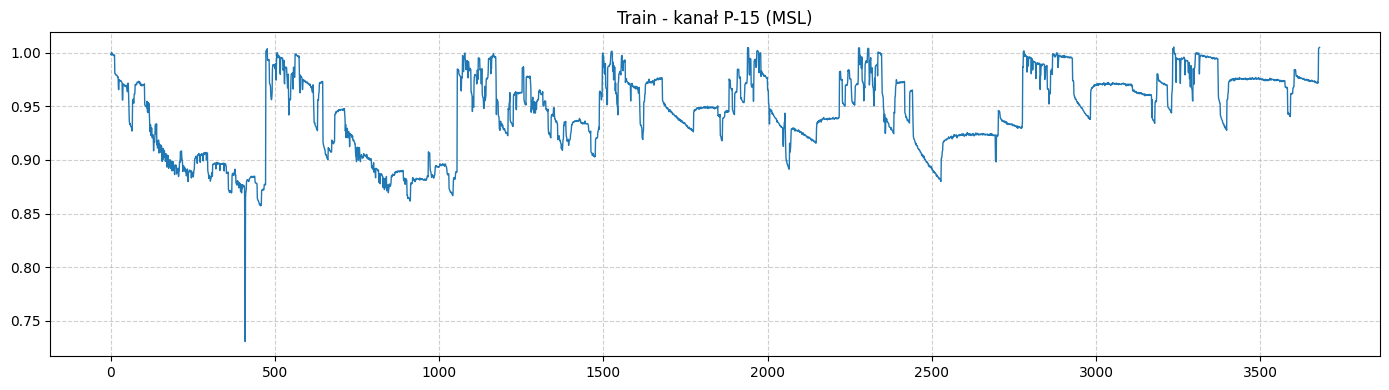

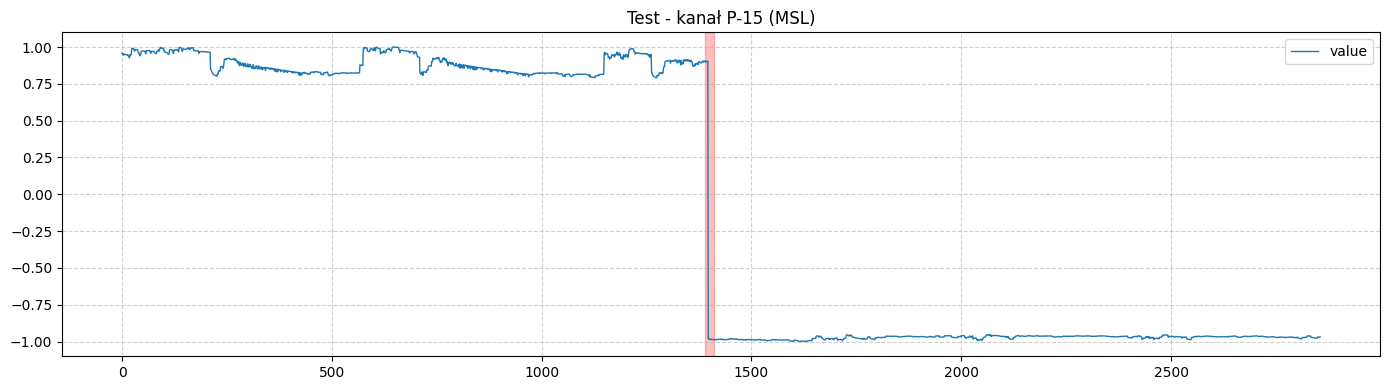

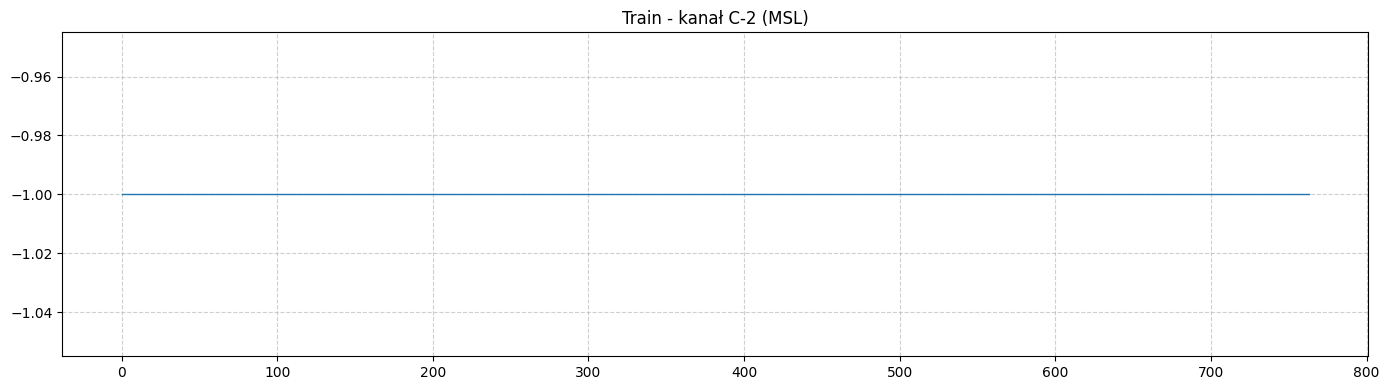

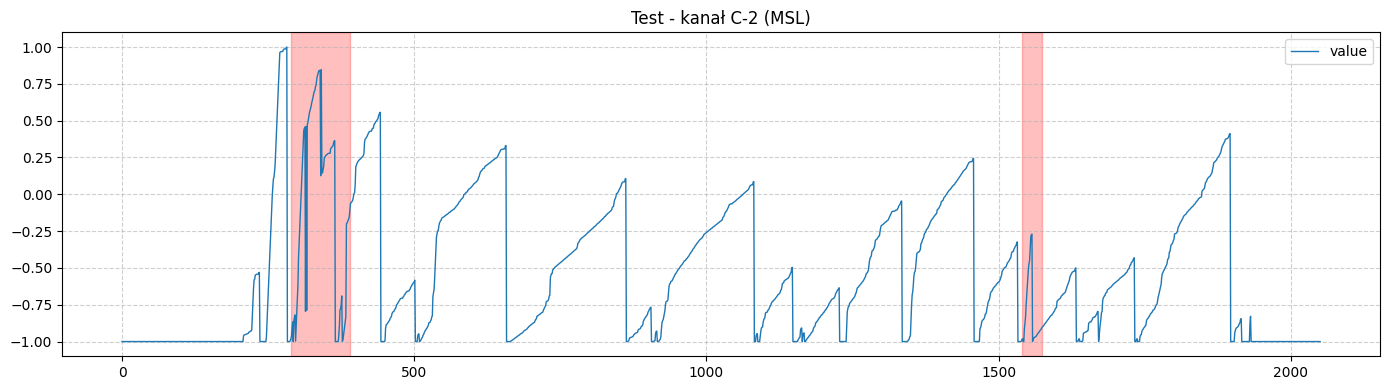

In [5]:
import matplotlib.pyplot as plt
import random
import numpy as np

number_of_plots = 5

# Losowy wybór kanałów
train_channels_sample = random.sample(list(train_data.keys()), min(number_of_plots, len(train_data)))

for channel in train_channels_sample:
    plt.figure(figsize=(14, 4))
    plt.plot(train_data[channel], linewidth=1)
    plt.title(f"Train - kanał {channel} (MSL)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    df = test_data_labeled[channel]
    x = np.arange(len(df))
    y = df['value']

    plt.figure(figsize=(14, 4))
    plt.plot(x, y, label="value", linewidth=1)

    # Zaznaczenie okresów anomalii
    in_anomaly = False
    start_idx = None
    for i, label in enumerate(df['Normal/Anomaly']):
        if label == 'Anomaly' and not in_anomaly:
            in_anomaly = True
            start_idx = i
        elif label == 'Normal' and in_anomaly:
            end_idx = i - 1
            plt.axvspan(start_idx, end_idx, color='red', alpha=0.25)
            in_anomaly = False
    if in_anomaly:
        plt.axvspan(start_idx, len(df)-1, color='red', alpha=0.25)

    plt.title(f"Test - kanał {channel} (MSL)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()